In [1]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
spectral_lines = np.array([
    22.181795919847822,
    41.140395614525275,
    144.26273501671918,
    186.4979599536216,
    292.1601184580567,
    335.21179409990134,
    377.61005873042376,
    414.14821455025987,
    445.4639986187941,
])
NEON_WAVELN = {
    532.640 : 20,
    533.078 : 60,
    533.331 : 0,
    533.571 : 0, 
    534.109 : 100,
    534.328 : 60,
    534.920 : 0,
    535.516 : 0,
    535.542 : 0,
    535.802 : 0,
    536.001 : 0,
    536.042 : 0,
    536.223 : 0,
    537.231 : 0,
    537.498 : 0,
    538.325 : 0,
    540.056 : 200,
    541.265 : 0,
    541.856 : 0,
}

In [3]:


def calculate_fingerprints(array, fingerprint_size):
    """"
    Calculate the fingerprints matrix for a given array and fingerprint size.
    
    The fingerprints matrix is sensitive to clusters of noisy data, especially for small fingerprint sizes.
    
    Parameters:
    array (numpy.ndarray): The input array of data points.
    fingerprint_size (int): The size of the fingerprint window.
    
    Returns:
    numpy.ndarray: The fingerprints matrix.
    
    Calculates the relative position of each point in array
    Returns a 2D array, where each row is the fingerprint of a point

    The current fingerprint architecture is sensitive incase of a small fingerprint size 
    to clusters of noisy data
    """
    if fingerprint_size>len(array):
        fingerprint_size = len(array)
    n = len(array)
    # initialize the fingerprints matrix
    fingerprints = np.zeros((n, n))
    # calculate the relative position of each point (matrix is symmetric)
    #iterating over all elements of the matrix
    for i in range(n): 
        for j in range(n):
            # arbitrary value for the diagonal
            if i == j:
                fingerprints[i, j] = 0
            # if the distance between the points is less than half the fingerprint size
            elif abs(i-j) < fingerprint_size/2:
                fingerprints[i, j] = (array[i] - array[j])/array[i]
            # if the point is close to the beginning of the array, maintain fingerprint size by adding points to the right
            elif i < fingerprint_size / 2 and abs(i-j) < fingerprint_size/2 + abs(i-fingerprint_size / 2):
                fingerprints[i, j] = (array[i] - array[j]) / array[i]
            # if the point is close to the end of the array, maintain fingerprint size by adding points to the left
            elif i > n - fingerprint_size / 2 and abs(i-j) < fingerprint_size/2 + n - i:
                fingerprints[i, j] = (array[i] - array[j]) / array[i]
    return fingerprints

# def match_fingerprints(mat_spl, mat_wldb):
    """
    Time to discover the matching fingerprints between the two matrices
    The smallest matrix, mat_spl should be matched with a unique entry in the larger matrix, mat_wldb
    These entries should be strictly increasing
    The optimal solution has the lowest sum of the differences between the matched entries
    BFS approach is used to find the optimal solution
    """
    rows_spl, _ = mat_spl.shape
    rows_wldb, __file__ = mat_wldb.shape
    if rows_spl > rows_wldb:
        raise 
    # Initialize the BFS queue
    queue = deque([(0, 0, 0, [])])  # (current row in mat_spl, current row in mat_wldb, current sum of differences, path)
    best_sum = float('inf')
    best_path = []

    while queue:
        row_spl, row_wldb, current_sum, path = queue.popleft()

        # If we have matched all rows in mat_spl
        if row_spl == rows_spl:
            if current_sum < best_sum:
                best_sum = current_sum
                best_path = path #  
            continue


        # Try to match the current row in mat_spl with each remaining row in mat_wldb
        for next_row_wldb in range(row_wldb, rows_wldb):
            wldb_row = mat_wldb[next_row_wldb][mat_wldb[next_row_wldb] != 0]
            spl_row = mat_spl[row_spl][mat_spl[row_spl] != 0]
            

            # the place of problems
            # if the current row in mat_spl is smaller than the current row in mat_wldb, truncate the latter
            if len(spl_row) < len(wldb_row):
                wldb_row = wldb_row[:len(spl_row)]
            print('spl_row', spl_row)
            print('wldb_row', wldb_row)

            diff = np.sum(np.abs(spl_row - wldb_row))
            new_sum = current_sum + diff
            new_path = path + [next_row_wldb]

            # Add the new state to the queue
            queue.append((row_spl + 1, next_row_wldb + 1, new_sum, new_path))

    return best_path, best_sum # best path is a list of the matched wavelengths from the database



In [4]:
from collections import deque
import numpy as np
from functools import lru_cache

@lru_cache(maxsize=1024)
def calculate_difference(spl_row_tuple, wldb_row_tuple):
    """Cache the difference calculations with length handling"""
    spl_arr = np.array(spl_row_tuple)
    wldb_arr = np.array(wldb_row_tuple)
    
    # Use the shorter length
    min_len = min(len(spl_arr), len(wldb_arr))
    return np.sum(np.abs(spl_arr[:min_len] - wldb_arr[:min_len]))

def match_fingerprints(mat_spl, mat_wldb, threshold=1e-6):
    """Optimized fingerprint matching with shape handling"""
    rows_spl, _ = mat_spl.shape
    rows_wldb, _ = mat_wldb.shape
    
    if rows_spl > rows_wldb:
        raise ValueError("mat_spl should have fewer rows than mat_wldb")
    
    # Precompute nonzero rows
    spl_rows = [tuple(row[row != 0]) for row in mat_spl]
    wldb_rows = [tuple(row[row != 0]) for row in mat_wldb]
    
    queue = deque([(0, 0, 0, [])])
    best_sum = float('inf')
    best_path = []
    
    # Calculate minimum differences with length handling
    min_diff_per_row = np.zeros(rows_spl)
    for i in range(rows_spl):
        diffs = []
        for wr in wldb_rows[i:]:
            if len(wr) > 0:  # Only consider non-empty rows
                diffs.append(calculate_difference(spl_rows[i], wr))
        min_diff_per_row[i] = min(diffs) if diffs else 0
    
    while queue:
        row_spl, row_wldb, current_sum, path = queue.popleft()
        
        if current_sum >= best_sum:
            continue
            
        if row_spl == rows_spl:
            if current_sum < best_sum:
                best_sum = current_sum
                best_path = path
            continue
        
        remaining_min_sum = sum(min_diff_per_row[row_spl:])
        if current_sum + remaining_min_sum >= best_sum:
            continue
            
        for next_row_wldb in range(row_wldb, rows_wldb):
            spl_row = spl_rows[row_spl]
            wldb_row = wldb_rows[next_row_wldb]
            
            if len(spl_row) == 0 or len(wldb_row) == 0:
                continue
                
            diff = calculate_difference(spl_row, wldb_row)
            new_sum = current_sum + diff
            
            if new_sum < best_sum:
                queue.append((row_spl + 1, next_row_wldb + 1, new_sum, path + [next_row_wldb]))
    
    return best_path, best_sum

In [5]:
spectral_fingerprints = calculate_fingerprints(spectral_lines, len(spectral_lines))
wl_fingerprints = calculate_fingerprints(np.array(list(NEON_WAVELN.keys())), len(NEON_WAVELN))
# print("Spectral fingerprints matrix:\n", spectral_fingerprints)
# print("Wavelength fingerprints matrix:\n", wl_fingerprints)

In [6]:
best_path, best_sum = match_fingerprints(spectral_fingerprints, wl_fingerprints)

In [7]:
# Extract the matched points
matched_spl = spectral_lines

print("Matched SPL points:", matched_spl)
print("Matched WLDB wavelengths:", np.array(list(NEON_WAVELN.keys()))[best_path])

Matched SPL points: [ 22.18179592  41.14039561 144.26273502 186.49795995 292.16011846
 335.2117941  377.61005873 414.14821455 445.46399862]
Matched WLDB wavelengths: [532.64  533.078 533.331 533.571 534.109 538.325 540.056 541.265 541.856]


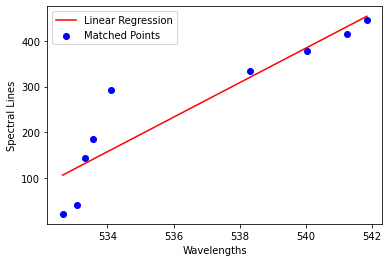

In [8]:
# Extract the matched wavelengths from NEON_WAVELN using best_path
matched_wavelengths = np.array(list(NEON_WAVELN.keys()))[best_path]

# Create a scatter plot
plt.scatter(matched_wavelengths, matched_spl, color='blue', label='Matched Points')

# Fit a linear regression model
model = LinearRegression()
model.fit(matched_wavelengths.reshape(-1, 1), matched_spl)

# Predict using the linear regression model
predicted_spl = model.predict(matched_wavelengths.reshape(-1, 1))

# Plot the linear regression line
plt.plot(matched_wavelengths, predicted_spl, color='red', label='Linear Regression')

# Add labels and legend
plt.xlabel('Wavelengths')
plt.ylabel('Spectral Lines')
plt.legend()
plt.show()

In [11]:
def filter_outliers(data, threshold=1.5):
    """
    Filter out outliers from a dataset using the IQR method.
    
    Parameters:
    data (numpy.ndarray): The input data array.
    threshold (float): The threshold for identifying outliers. Default is 1.5.
    
    Returns:
    numpy.ndarray: The filtered data with outliers removed.
    """
    # Calculate the first and third quartiles
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    
    # Calculate the IQR
    IQR = Q3 - Q1
    
    # Determine the bounds for outliers
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    # Filter the data
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]
    
    return filtered_data

# Example usage
filtered_spectral_lines = filter_outliers(spectral_lines)


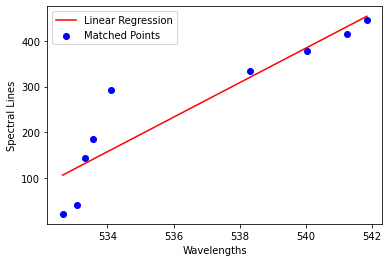

In [12]:
# Create a scatter plot
plt.scatter(matched_wavelengths, filtered_spectral_lines, color='blue', label='Matched Points')

# Fit a linear regression model
model = LinearRegression()
model.fit(matched_wavelengths.reshape(-1, 1), filtered_spectral_lines)

# Predict using the linear regression model
predicted_spl = model.predict(matched_wavelengths.reshape(-1, 1))

# Plot the linear regression line
plt.plot(matched_wavelengths, predicted_spl, color='red', label='Linear Regression')

# Add labels and legend
plt.xlabel('Wavelengths')
plt.ylabel('Spectral Lines')
plt.legend()
plt.show()